In [1]:
!nvidia-smi

Tue Jan 19 13:58:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   31C    P0    33W / 250W |    743MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   32C    P0    32W / 250W |   1885MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
import sys
import pathlib
import functools
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchvision.transforms import *
import time
from tqdm import tqdm

In [3]:
sys.path.insert(0,'/home/Druzhinina/project')
from data import HCP_MRI

In [4]:
random.seed(82)
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# CHECKPOINTS_DIR = '/home/Druzhinina/project/checkpoints_skull/' #best_acc_model_NetGradRandomiz_all_subject_bs42
CHECKPOINTS_DIR = '/home/Druzhinina/project/checkpoints_skull'

In [5]:
PATH_TO_MRI = '/home/datasets/HCP_T1_fsl/HCP_T1_pm'
data_dir = pathlib.Path('/home/datasets/adni')
behavioral_path = os.path.join('/home/datasets/adni', 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

HCP absmax before normalization: 435.0126647949219
Dataset size: 1112
Labels distribution: (array([0, 1]), array([605, 507]))

Example:
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


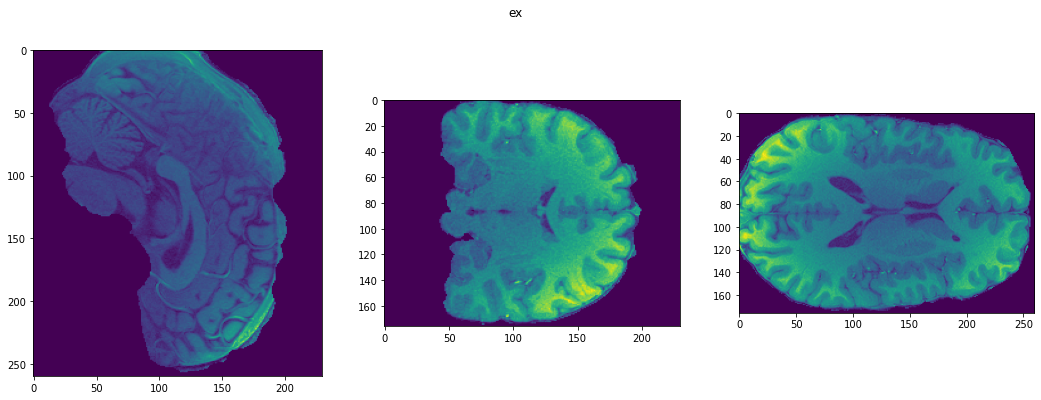

In [6]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
    
hcp_dataset = HCP_MRI(
    paths= PATH_TO_MRI,
    target_path= behavioral_path,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40,25,55),
    img_shape=(176, 260, 230)
)
hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)

transform = Compose([
#     BrightnessContrast(),
#     GaussNoise(),
#     Rotate(),
    ToTensor(),
])
hcp_dataset.transform = transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Dataset size: {}".format(len(hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(hcp_dataset.labels, return_counts=True)))

print("Example:")
img, target = hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [116]:
target

1

In [100]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(c, 2*c, kernel_size=3),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=3),
            nn.Flatten(),
#             nn.Linear(in_features=4*c*5*5*5, out_features=2),
            nn.Linear(in_features=35840, out_features=2)
        )
        self.gradients = None
        
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [101]:
if torch.cuda.is_available():
  device = torch.device("cuda:3")
else:
  device = torch.device("cpu")

if torch.cuda.device_count() > 1:
      d_ids= [3,1,0]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

Let's use [3, 1, 0] GPUs!


In [77]:
def get_prediction(net, data_loader, device):
    net.eval()
    pred_list = []
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred_list.append(out.data.max(1)[1].detach().cpu().numpy()) 
        del data, target,out
    return pred_list

In [86]:
  
def get_masks(model, loader, device, mask_type='grad_cam', size = (180,180,180)):
    masks = []
    for image, gt in tqdm(loader, total=len(loader)):
        image = image.to(device)
        logit = model(image)
        if mask_type == 'grad_cam':
            print(logit)
            print(logit[:,1])
            print('diff')
            print(logit.data.max(1)[1].item())
            logit[:,logit.data.max(1)[1].item()].backward()
            print(logit)
            activation = model.get_activations(image).detach()
            print(activation)
            act_grad  = model.get_activations_gradient()
            pool_act_grad = torch.mean(act_grad, dim=[2,3,4], keepdim=True)
            print('pool')
            print(pool_act_grad)
            activation = activation * pool_act_grad
            print(activation)
            heatmap = torch.sum(activation, dim=1)
            print('heatmap')
            print(heatmap)
            heatmap = F.relu(heatmap)
            heatmap /= torch.max(heatmap)
            heatmap = F.interpolate(heatmap.unsqueeze(0),size, mode='trilinear', align_corners=False) #58 70 58
#             print(heatmap)
            masks.append(heatmap.cpu().numpy())
            print('mask')
            print(masks)
        elif mask_type == 'guided_backprop':
            pred = logit.data.max(1)[1].item()
            img_grad = gp.guided_backprop(image, pred)
            masks.append(img_grad)
        else:
            raise NotImplementedType('define mask_type')
    return np.concatenate(masks,axis=0).squeeze(axis=1)
        

In [117]:
X_train_ind, X_test_ind, y_train_ind, y_test_ind = train_test_split(np.arange(len(hcp_dataset)), hcp_dataset.labels, test_size=0.2, stratify=hcp_dataset.labels, random_state=42)
train_loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, X_train_ind),
                                          shuffle=True,
                                          batch_size=4)
val_loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, X_test_ind),
                                    shuffle=False,
                                    batch_size=2)

In [137]:
def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)
        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()

In [138]:
get_accuracy(model, val_loader)

100%|██████████| 112/112 [01:20<00:00,  1.39it/s]


95.06726837158203

In [102]:
model = model.to(device)
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_NetGrad_skull_strip_bs42'), map_location=device))#change path
model.eval()
loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, np.arange(2)), batch_size=1, shuffle=False)
# masks_grad = get_masks(model.module, loader, device, mask_type='grad_cam', size =hcp_dataset[0][0].shape[1:] )

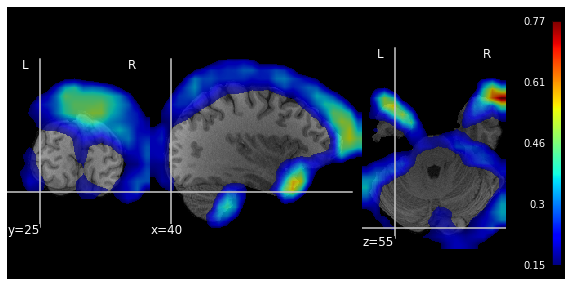

In [82]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad[1],affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[1][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img ,cut_coords=(40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.15)
plt.show()
# fig.savefig("grad_cam_rand_male_1_0.65.png", bbox_inches='tight')

In [89]:
masks_grad[1]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [90]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2,),
                
                nn.Conv3d(c, 2*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1896960, out_features=2), #4*c*5*7*5
        )
        self.gradients = None
        
     
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [91]:
if torch.cuda.is_available():
  device = torch.device("cuda:3")
else:
  device = torch.device("cpu")

if torch.cuda.device_count() > 1:
      d_ids= [3,1,0]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

Let's use [3, 1, 0] GPUs!


In [92]:
model = model.to(device)
model.load_state_dict(torch.load(os.path.join('/home/Druzhinina/project/checkpoints_work_gradcam', 'best_acc_model__checkpoints_work_gradcam'), map_location=device))#change path
model.eval()
loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, np.arange(2)), batch_size=1, shuffle=False)
masks_grad = get_masks(model.module, loader, device, mask_type='grad_cam', size =hcp_dataset[0][0].shape[1:] )

  0%|          | 0/2 [00:00<?, ?it/s]

tensor([[-66.6532,  63.6718]], device='cuda:3', grad_fn=<AddmmBackward>)
tensor([63.6718], device='cuda:3', grad_fn=<SelectBackward>)
diff
1
tensor([[-66.6532,  63.6718]], device='cuda:3', grad_fn=<AddmmBackward>)
tensor([[[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0

 50%|█████     | 1/2 [00:00<00:00,  1.01it/s]

mask
[array([[[[[0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          ...,
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366]],

         [[0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          ...,
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366

100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

mask
[array([[[[[0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          ...,
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366]],

         [[0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366,
           0.22062366, 0.22062366],
          ...,
          [0.22062366, 0.22062366, 0.22062366, ..., 0.22062366

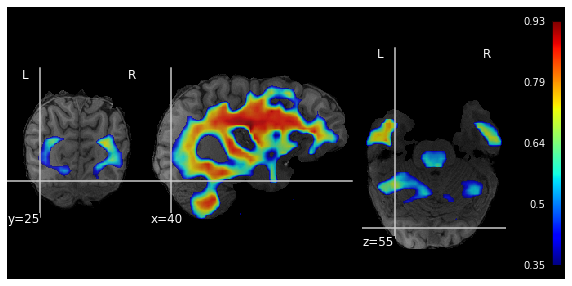

In [96]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(masks_grad[0],affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[0][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img ,cut_coords=(40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()

In [139]:
loader = torch_data.DataLoader(torch_data.Subset(hcp_dataset, np.arange(2)), batch_size=1, shuffle=False)

In [141]:
hcp_dataset[0][0]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

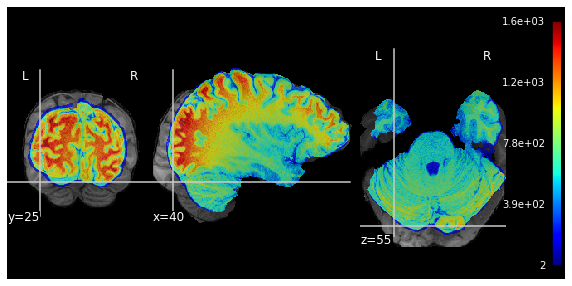

In [39]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(np.squeeze(hcp_dataset[1][0].numpy()),affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[10][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img ,cut_coords=(40, 25, 55), axes=axes,colorbar=True,cmap='jet',threshold=0.35)
plt.show()

In [154]:
hcp_dataset.labels[:100]

array([1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0])

In [37]:
hcp_dataset.labels[20]

1